In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'differential_apa_abundance_c2c12',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from lapa.result import LapaResult

In [14]:
samples = ['PB154', 'PB155', 'PB213', 'PB214']

In [4]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '/home/cs/Projects/lapa/data/resources/c2c12/bulk_talon_abundance.tsv'

In [ ]:
df_count = df_abundance.rename(columns={'annot_gene_id': 'gene_id'}).groupby('gene_id')[samples].agg('sum')

In [ ]:
df_count['dif'] = df_count[['PB213', 'PB214']].sum(axis=1)
df_count['undif'] = df_count[['PB154', 'PB155']].sum(axis=1)
df_count['log(FC)'] = np.log(df_count['dif'] / df_count['undif'])
df_count['total'] = df_count['dif'] + df_count['undif']

In [ ]:
df_count

In [3]:
result = LapaResult(snakemake.input['long_read'])
df = result.fisher_exact_test({'undif': ['PB154', 'PB155'], 'dif': ['PB213', 'PB214']}, min_gene_count=50)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14371/14371 [01:39<00:00, 144.87it/s]


In [ ]:
chrom, pos, strand = zip(*df.reset_index().rename(columns={'index': 'polya_site'})['polya_site'].str.split(':'))
df['Chromosome'] = chrom
df['Start'] = pos
df['Start'] = df['Start'].astype(int)
df['End'] = df['Start'] + 1
df['Strand'] = strand

In [32]:
df = df[(df['delta_usage'].abs() > 0.3) & (df['pval_adj'] < 0.05)]

In [35]:
df

,odds_ratio,pval,delta_usage,gene_id,pval_adj,Chromosome,Start,End,Strand
chr10:100100411:+,0.137313,4.701520e-03,-0.359279,ENSMUSG00000019966.18,1.595785e-02,chr10,100100411,100100412,+
chr10:100443913:-,0.095238,9.124634e-05,-0.543594,ENSMUSG00000036676.14,4.602672e-04,chr10,100443913,100443914,-
chr10:108261036:+,15.272340,5.075524e-25,0.557175,ENSMUSG00000019907.10,1.624507e-23,chr10,108261036,108261037,+
chr10:111297247:+,0.177489,3.617802e-03,-0.403852,ENSMUSG00000020189.15,1.264831e-02,chr10,111297247,111297248,+
chr10:120231659:+,0.224090,3.044290e-09,-0.333348,ENSMUSG00000020224.15,3.008906e-08,chr10,120231659,120231660,+
...,...,...,...,...,...,...,...,...,...
chrX:74014998:-,30.000000,1.244682e-07,0.677186,ENSMUSG00000031392.18,1.003215e-06,chrX,74014998,74014999,-
chrX:77660095:+,3.814893,2.521792e-08,0.308248,ENSMUSG00000025246.13,2.227454e-07,chrX,77660095,77660096,+
chrX:77662984:+,0.219501,4.427994e-10,-0.334317,ENSMUSG00000025246.13,4.809879e-09,chrX,77662984,77662985,+
chrX:95935326:-,0.062101,6.620729e-32,-0.385167,ENSMUSG00000057421.12,2.828810e-30,chrX,95935326,95935327,-


In [36]:
df.loc[df[df['Strand'] == '+'].groupby('gene_id')['End'].idxmax(), 'distal'] = True
df.loc[df[df['Strand'] == '-'].groupby('gene_id')['Start'].idxmin(), 'distal'] = True
df['distal'] = ~df['distal'].isna()

In [37]:
df['distal'].sum(), df.shape[0]

(734, 1014)

In [21]:
df = df.set_index('gene_id').join(df_count)

In [24]:
df['distal']

gene_id
ENSMUSG00000000078.7     False
ENSMUSG00000000078.7      True
ENSMUSG00000000223.13    False
ENSMUSG00000000223.13     True
ENSMUSG00000000253.13     True
                         ...  
ENSMUSG00000111497.1      True
ENSMUSG00000111497.1     False
ENSMUSG00000114797.1      True
ENSMUSG00000116275.1      True
ENSMUSG00000116275.1     False
Name: distal, Length: 861, dtype: bool

In [25]:
_df = df[df['distal']]

In [35]:
df_boxplot = df[['usage_undif', 'usage_dif']].melt()

In [36]:
df_boxplot

,variable,value
0,usage_undif,0.741784
1,usage_undif,0.248826
2,usage_undif,0.832061
3,usage_undif,0.083969
4,usage_undif,1.000000
...,...,...
1717,usage_dif,0.810127
1718,usage_dif,0.139241
1719,usage_dif,0.337423
1720,usage_dif,0.608483


<AxesSubplot:xlabel='variable', ylabel='value'>

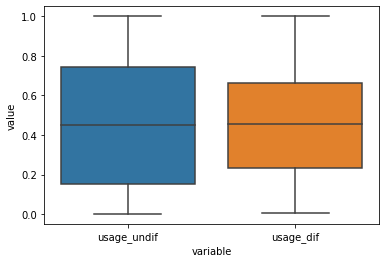

In [37]:
import seaborn as sns

sns.boxplot(data=df_boxplot, x='variable', y='value')

In [51]:
from scipy.stats import mannwhitneyu

In [54]:
_df[_df['Distal polyA-site usage'] == 'less']['log(FC)']

gene_id
ENSMUSG00000000253.13    1.575536
ENSMUSG00000000567.5     0.053776
ENSMUSG00000000686.11    1.481605
ENSMUSG00000000787.12   -0.266140
ENSMUSG00000000976.13    0.158470
                           ...   
ENSMUSG00000092329.1     1.884683
ENSMUSG00000096199.2     0.503104
ENSMUSG00000096740.8    -0.587787
ENSMUSG00000111409.1     4.248495
ENSMUSG00000114797.1    -1.293246
Name: log(FC), Length: 236, dtype: float64

In [55]:
_df[_df['Distal polyA-site usage'] == 'more']['log(FC)']

gene_id
ENSMUSG00000000078.7    -1.495109
ENSMUSG00000000223.13   -0.576091
ENSMUSG00000000957.11   -0.590052
ENSMUSG00000001016.12   -1.229014
ENSMUSG00000001151.10   -0.491540
                           ...   
ENSMUSG00000102976.6     0.667246
ENSMUSG00000106106.3          NaN
ENSMUSG00000111080.1     3.569533
ENSMUSG00000111497.1    -2.233592
ENSMUSG00000116275.1    -1.039423
Name: log(FC), Length: 357, dtype: float64

In [60]:
_df = _df.dropna(subset=['log(FC)'])

/data/homezvol2/mcelik/.conda/envs/lapa/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


MannwhitneyuResult(statistic=28458.0, pvalue=1.3773901182186508e-08)

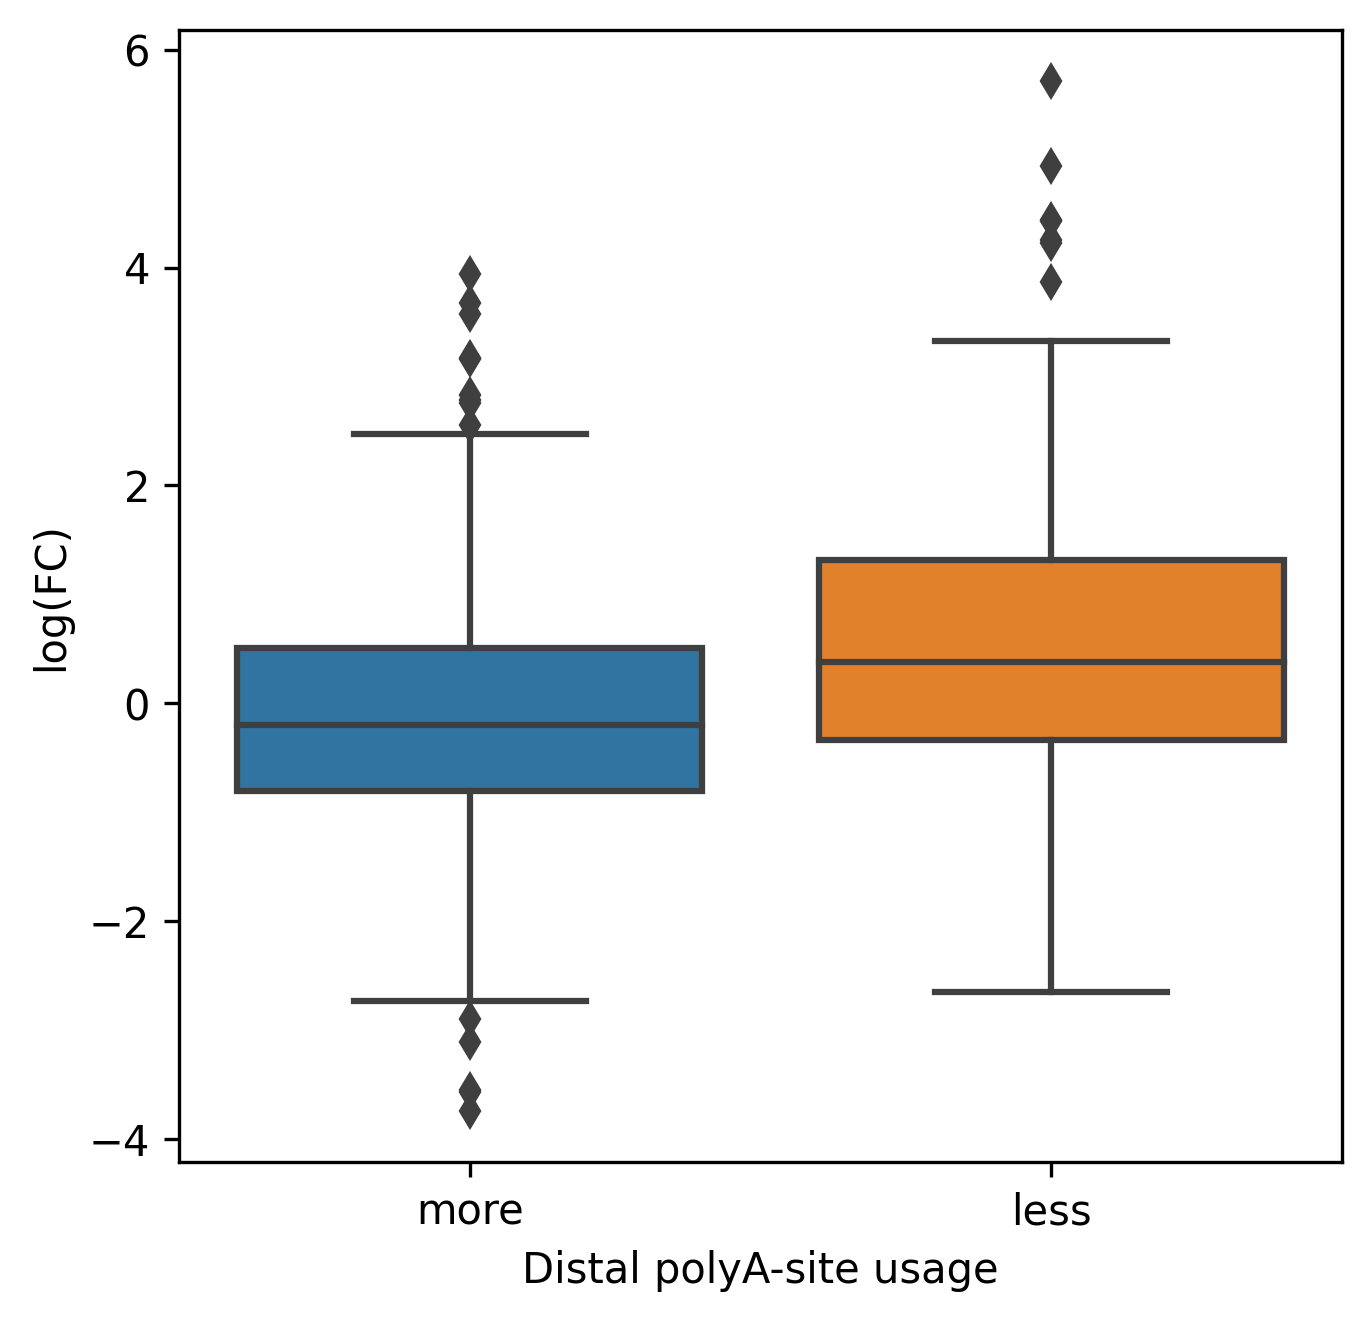

In [61]:
_df['Distal polyA-site usage'] = np.where(_df['delta_usage'] > 0, 'more', 'less')

plt.figure(figsize=(5, 5), dpi=300)

sns.boxplot(data=_df, x='Distal polyA-site usage', y='log(FC)')

mannwhitneyu(
    _df[_df['Distal polyA-site usage'] == 'more']['log(FC)'],
    _df[_df['Distal polyA-site usage'] == 'less']['log(FC)']
)